In [4]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate
from numpy import pi, random

#### Pour tester le jeux, vous devez créer un environement virtuel avec python 1.12+, installer les package dans requirements.txt 

#### et faire la commande `python -m the_game` dans le root du repo. des screenshots du jeux sont mis plus en bas dans ce notebook

Voir le README.md pour plus de détail sur comment le jeux fonctionne et les différents concept en quantique intégré

Lors du déplacement de notre personnage, nous utilisons un Quantum Random Walk afin de trouver une valeur aléatoire

('000', '001', '010', '011', '100', '101', '110')
(161, 1619, 834, 1190, 2043, 3998, 155)


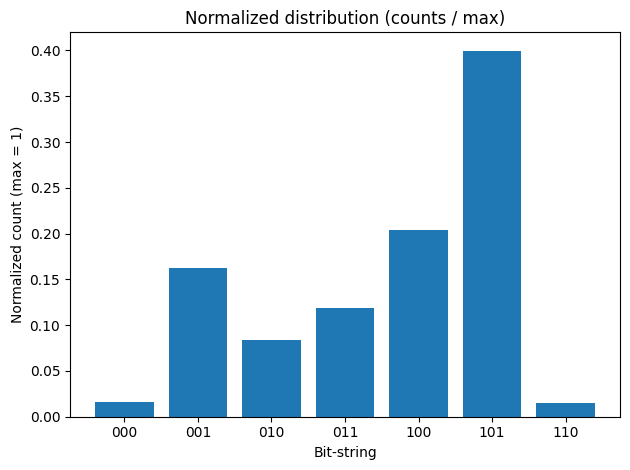

Dice roll: 6


In [175]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt

_simulator = AerSimulator()
def plotting_stuff(counts):
    """Plotting stuff.
    """
    sorted_items = sorted(
        counts.items(),
        key=lambda kv: int(kv[0], 2)        # use kv[0] because kv = (key, value)
    )    # -> [('000', 3), ('010', 12), ('011', 7)]

    # 2️⃣  If you just need parallel lists:
    keys_sorted, counts_sorted = zip(*sorted_items)

    # lists() if you really need list objects instead of tuples
    keys   = list(keys_sorted)
    counts = list(counts_sorted)

    print(keys_sorted)    # ['000', '010', '011']
    print(counts_sorted)  # [3, 12, 7]

    # 3️⃣  Or rebuild an ordered dict / regular dict (3.7+ preserves insertion order):
    sorted_counts = dict(sorted_items)

    # Normalization (0‑1 range) – divide by the maximum count
    max_count = sum(counts)
    normalized = [c / max_count for c in counts]

    # Plot
    plt.figure()
    plt.bar(keys, normalized)
    plt.xlabel('Bit‑string')
    plt.ylabel('Normalized count (max = 1)')
    plt.title('Normalized distribution (counts / max)')
    plt.tight_layout()
    plt.show()

def controlled_displacement(qc):
        qc.mcx([0,1,2], 3, ctrl_state=None, mode='noancilla')
        qc.mcx([0,1], 2, ctrl_state=None, mode='noancilla')
        qc.mcx([0,], 1, ctrl_state=None, mode='noancilla')
        return qc

def quantum_walk_roll(step=6):
    """Return a dice roll using a quantum walk.
    """
    get_out = 0
    while get_out <= 1000:
        qc = QuantumCircuit(4, 3)
        qc.x(0)
        qc.h(0)
        random_walk_nb_steps = step
        for i in range(random_walk_nb_steps):
            qc = controlled_displacement(qc)
            qc.h(0)
        qc.measure([1, 2, 3], [0, 1, 2])
        qc.draw(output='mpl', filename='quantum_walk_roll.png', fold=-1)
        result = _simulator.run(qc, shots=10000).result()
        counts = result.get_counts()
        outcome = list(counts.keys())[0]
        value = int(outcome, 2)


        get_out += 1
        if value < 6: # s'assure qu'on reste entre 0 et 6
            plotting_stuff(counts)
            return value + 1
value = quantum_walk_roll(6)
print(f"Dice roll: {value}")


Notre mini jeux quantique utilise qiskit. le but est de maximiser un résultat dépendemment du résultat voulue du joueur (01 et 10 bloque certain passages, 11 inverse tout les chemins, 00 fait rien)

In [3]:
import pygame
import sys
from main_challenge.QuantumCircuit.Player import Player  # Import Player from external file
from main_challenge.QuantumCircuit.CircuitSimulator import CircuitSimulator
from main_challenge.QuantumCircuit.GameUI import GameUI

from qiskit import QuantumCircuit
from qiskit_aer.noise import NoiseModel, depolarizing_error

# --- Game Setup ---

pygame.init()
WIDTH, HEIGHT = 1500, 600  
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Quantum Gate Minigame")
font = pygame.font.SysFont(None, 32)
players = [Player("Mario"), Player("Luigi"), Player("Yoshi"), Player("Peach")]
current_player = 0
skipped_players = set()

# --- Gate UI Setup ---

GATE_COLORS = {"H": (200,200,255),"Z": (255,200,200),"Y": (200,255,200),"X": (255,255,200),"CNOT": (200,255,255),"SWAP": (255,200,255), "DECOH": (120,120,120)}
GATE_LIST = ["H","Z","Y","X","CNOT","SWAP"]
gate_rects = {}
for i, gate in enumerate(GATE_LIST):
    gate_rects[gate] = pygame.Rect(30, 50 + i*60, 80, 40)

# --- Circuit State ---
MAX_GATES = 20

qiskit_circuit = CircuitSimulator.create_empty_circuit()
gate_history = [("H", 0), ("H", 1, "layer0")]  

# --- Decoherence State ---

def get_decoherence_percent():
    # Decoherence is now 10% per DECOH gate (max 100)
    decoh_gates = [g for g in gate_history if g[0] == "DECOH"]
    percent = min(100, len(decoh_gates) * 20)
    return percent


# --- Drag and Drop ---
dragging_gate = None
drag_offset = (0,0)
drag_pos = (0,0)

# --- Main Loop ---

measurement_result = None

def next_player():
    global current_player
    n = len(players)
    for _ in range(n):
        current_player = (current_player + 1) % n
        if current_player not in skipped_players:
            return

while True:
    screen.fill((240,240,240))
    GameUI.draw_player_info(screen, font, players, current_player)
    GameUI.draw_gates(screen, font, players[current_player], players, current_player, gate_rects, GATE_LIST, GATE_COLORS)
    GameUI.draw_circuit(screen, font, gate_history, GATE_COLORS, MAX_GATES)
    btn_rect = GameUI.draw_measure_button(screen, font, WIDTH, HEIGHT)
    skip_btn_rect = GameUI.draw_skip_button(screen, font, WIDTH, HEIGHT)
    # Draw decoherence percent
    
    decoh_percent = get_decoherence_percent()

    decoh_txt = font.render(f"Decoherence chance: {decoh_percent}%", True, (120,0,0))

    screen.blit(decoh_txt, (WIDTH-350, HEIGHT-180))
    if measurement_result:
        txt = font.render(f"Measured: {measurement_result}", True, (0,0,0))
        screen.blit(txt, (WIDTH-300, HEIGHT-140))
    # Draw dragging gate if any
    if dragging_gate:
        mx, my = drag_pos
        pygame.draw.rect(screen, GATE_COLORS[dragging_gate], (mx-40, my-20, 80, 40))
        txt = font.render(dragging_gate, True, (0,0,0))
        screen.blit(txt, (mx-20, my-10))
    pygame.display.flip()

    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            pygame.quit()
            sys.exit()
        elif event.type == pygame.MOUSEBUTTONDOWN:
            mx, my = event.pos
            if skip_btn_rect.collidepoint(mx, my):
                skipped_players.add(current_player)
                next_player()
                dragging_gate = None
                drag_pos = (0,0)
                continue
            for gate, rect in gate_rects.items():
                if rect.collidepoint(mx, my) and players[current_player].gates[gate] > 0:
                    dragging_gate = gate
                    drag_offset = (mx - rect.x, my - rect.y)
                    drag_pos = (mx, my)
            if btn_rect.collidepoint(mx, my):
                # Apply decoherence noise model
                percent = get_decoherence_percent()
                noise_model = CircuitSimulator.apply_decoherence_noise(qiskit_circuit, percent)
                measurement_result = CircuitSimulator.apply_circuit(qiskit_circuit, noise_model=noise_model,gate_history=gate_history)
        elif event.type == pygame.MOUSEBUTTONUP:
            if dragging_gate:
                mx, my = event.pos
                base_x = 200
                gate_layer = max(0, len(gate_history) - 2)
                drop_x = base_x + (gate_layer+2)*60
                dropped = False
                for q in range(2):
                    y = 150 + q*60
                    if drop_x-20 < mx < drop_x+20 and y-20 < my < y+20:
                        if dragging_gate == "CNOT":
                            control = q
                            target = 1 - q
                            qiskit_circuit.cx(control, target)
                            gate_history.append(("CNOT", control, target))
                            players[current_player].gates["CNOT"] -= 1
                            next_player()
                            measurement_result = None
                            dropped = True
                            break
                        elif dragging_gate == "SWAP":
                            qiskit_circuit.swap(0, 1)
                            gate_history.append(("SWAP", 0, 1))
                            players[current_player].gates["SWAP"] -= 1
                            next_player()
                            measurement_result = None
                            dropped = True
                            break
                        else:
                            if dragging_gate == "H":
                                qiskit_circuit.h(q)
                            elif dragging_gate == "X":
                                qiskit_circuit.x(q)
                            elif dragging_gate == "Y":
                                qiskit_circuit.y(q)
                            elif dragging_gate == "Z":
                                qiskit_circuit.z(q)
                            gate_history.append((dragging_gate, q))
                            players[current_player].gates[dragging_gate] -= 1
                            next_player()
                            measurement_result = None
                            dropped = True
                            break
                # Insert decoherence gate every 4 user-placed gates
                placed_gates = [g for g in gate_history[2:] if g[0] != "DECOH"]
                if len(placed_gates) > 0 and len(placed_gates) % 4 == 0:
                     gate_history.append(("DECOH", None))
                dragging_gate = None
                drag_pos = (0,0)
        elif event.type == pygame.MOUSEMOTION:
            if dragging_gate:
                drag_pos = event.pos

SystemExit: 

c:\Users\Kuift\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Notre menu principal

![System diagram](resources/starting_menu.JPG)

### Notre réseaux de noeuds directionel sans bloquage
![System diagram](resources/game_1.JPG)
### Réseaux de noeuds directionel avec bloquage après avoir mesuré 01 ou 10
![System diagram](resources/game_2.JPG)

### Image du mini-jeu quantique dont le but est de choisir un état favorable pour gagner une étoile. La mesure affecte la carte au complet

![System diagram](resources/editeur_2.jpg)

### Win condition/image du gagnant
La win condition : celui qui a collecter le plus d'étoile (*) + le plus de gates gagne

![System diagram](resources/winning_screen.JPG)